### Initial package imports

In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

## Initial files being read in and dataset creation

In [2]:
pd.set_option('display.float_format', '{:.6f}'.format)
# Read the data
main_df = pd.read_csv('Data/Cleaned_Indices_Assignment1.csv', sep=';')

# Read the interest rate data
#interest_rate_df = pd.read_csv('Data/ECB_Rates_2012_to_2022.csv', sep=';')
interest_rate_bond_df = pd.read_csv('Data/ECB_Data_10yr_Treasury_bond.csv', sep=',')

# Convert date columns to datetime format for proper merging
main_df['Date'] = pd.to_datetime(main_df['Date'], format='%d-%m-%Y')
#interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['Date'], format='%d-%m-%Y')
#gov_bond_investment_df['Date'] = pd.to_datetime(gov_bond_investment_df['Date'], format='%Y-%m-%d')
interest_rate_bond_df['Date'] = pd.to_datetime(interest_rate_bond_df['Date'], format='%Y-%m-%d')

# Merge the dataframes on the Date column
main_df = pd.merge(main_df, interest_rate_bond_df, on='Date', how='left')
#main_df = pd.merge(main_df, gov_bond_investment_df, on='Date', how='left')

# Remove rows where the bond does not have a yield curve spot rate (Market closed?)
main_df = main_df.dropna(axis=0, subset=['Yield curve spot rate, 10-year maturity - Government bond'])

# Filter the dataframe to start from 2012-01-04
main_df = main_df[main_df['Date'] >= '2012-01-04']
main_df = main_df.reset_index(drop=True)

### government bond column

In [3]:
	
# Add a column for the interest bond value per day
days_per_annum = 365
interest_bond = 1500000

# Initialize the arrays with appropriate lengths matching the DataFrame
interest_bond_vector = np.zeros(len(main_df))
interest_bond_profit_vector = np.zeros(len(main_df))
interest_bond_loss_vector = np.zeros(len(main_df))
daily_rates = np.zeros(len(main_df))

# Set initial value
interest_bond_vector[0] = interest_bond


# Calculate bond values day by day based on the daily yield rate
for i in range(len(main_df)):
    # Adding 1.5% to account for the credit risk spread
    daily_rate = (((main_df['Yield curve spot rate, 10-year maturity - Government bond'].iloc[i] + 1.5) / (days_per_annum)) * (7/5)) / 100
    daily_rates[i] = daily_rate
    
    if i > 0:
        previous_value = interest_bond_vector[i-1]
        current_value = previous_value * (1 + daily_rate)
        interest_bond_vector[i] = current_value
        
        # Calculate change, profit/loss and return
        change = current_value - previous_value
        interest_bond_profit_vector[i] = change
        interest_bond_loss_vector[i] = -change

# Add vectors to the dataframe
main_df['Interest_Bond'] = interest_bond_vector
main_df['Interest_Bond_Profit'] = interest_bond_profit_vector
main_df['Interest_Bond_Loss'] = interest_bond_loss_vector
main_df['Interest_Bond_daily_rate'] = daily_rates




## Portfolio details

### details

#### Instruments:
- **S&P500**
- **DAX40**
- **NIKKEI**
- **EU Government Bond (10-year maturity, AAA-rated)**

#### Invested amount:
- **10,000,000 EURO**

#### Period:
- **01/01/2012 - 31/12/2022**

#### Weights:
- **S&P500**: 0.4  
- **DAX40**: 0.3  
- **NIKKEI**: 0.15  
- **EU Government Bond**: 0.15  

#### Measures:
- **Value at Risk (VaR)**: 1, 5, 10 days  
- **Expected Shortfall (ES)**  



### weights and currency correction


In [4]:
# initial investment 
weights = {
    'S&P500': 0.4,
    'DAX40': 0.3,
    'NIKKEI': 0.15,
    'EU-BOND': 0.15,
}

starting_investment = 10000000  # 10 million euros
starting_date = '2012-01-04'

# Filter the main_df for the starting date
starting_row = main_df[main_df['Date'] == starting_date]

# Extract the exchange rates for the starting date
usd_to_eur = float(starting_row['USD/EUR'].iloc[0])
jpy_to_eur = float(starting_row['JPY/EUR'].iloc[0])

# Calculate the invested amounts
invested_amount_SP500 = starting_investment * weights['S&P500'] / usd_to_eur
invested_amount_DAX40 = starting_investment * weights['DAX40']
invested_amount_NIKKEI = starting_investment * weights['NIKKEI'] / jpy_to_eur
invested_amount_EU_BOND = starting_investment * weights['EU-BOND']

invested_amounts = [
    invested_amount_SP500, #in USD
    invested_amount_DAX40, #in EUR
    invested_amount_NIKKEI, #in JPY
    invested_amount_EU_BOND #in EUR
]

print(invested_amounts)

[5177993.527508091, 3000000.0, 148957298.90764648, 1500000.0]


### Returns Portfolio 

In [5]:
# Create columns to track investments for each asset
# Initialize the first day with the initial invested amounts
main_df.loc[0, 'SP500_Investment'] = invested_amount_SP500
main_df.loc[0, 'DAX40_Investment'] = invested_amount_DAX40
main_df.loc[0, 'NIKKEI_Investment'] = invested_amount_NIKKEI
main_df.loc[0, 'EU_BOND_Investment'] = invested_amount_EU_BOND

# Calculate daily investment values for subsequent days
# This uses cumulative returns to track the value growth
for i in range(1, len(main_df)):
    # S&P 500 in USD
    main_df.loc[i, 'SP500_Investment'] = main_df.loc[i-1, 'SP500_Investment'] * (1 + main_df.loc[i, 'C_S&P500_Returns'])
    
    # DAX 40 in EUR
    main_df.loc[i, 'DAX40_Investment'] = main_df.loc[i-1, 'DAX40_Investment'] * (1 + main_df.loc[i, 'C_Dax40_Returns'])
    
    # NIKKEI in JPY
    main_df.loc[i, 'NIKKEI_Investment'] = main_df.loc[i-1, 'NIKKEI_Investment'] * (1 + main_df.loc[i, 'C_Nikkei_Returns'])
    
# EU Government Bond value is already calculated in the Interest_Bond column
main_df['EU_BOND_Investment'] = main_df['Interest_Bond']

In [6]:
main_df

,Date,S&P500_Closing,Dax40_Closing,Nikkei_Closing,U_S&P500_Returns,U_Dax40_Returns,U_Nikkei_Returns,U_S&P500_Loss,U_Dax40_Loss,U_Nikkei_Loss,...,TIME PERIOD,"Yield curve spot rate, 10-year maturity - Government bond",Interest_Bond,Interest_Bond_Profit,Interest_Bond_Loss,Interest_Bond_daily_rate,SP500_Investment,DAX40_Investment,NIKKEI_Investment,EU_BOND_Investment
0,2012-01-04,1277.300000,6111.550000,8560.110000,NaN,NaN,NaN,NaN,NaN,NaN,...,04 Jan 2012,2.776691,1500000.000000,0.000000,0.000000,0.000164,5177993.527508,3000000.000000,148957298.907646,1500000.000000
1,2012-01-05,1281.060000,6095.990000,8488.710000,0.002939,-0.002549,-0.008376,-3.760000,15.560000,71.400000,...,05 Jan 2012,2.784807,1500246.523142,246.523142,-246.523142,0.000164,5189897.180583,2992352.262000,148944667.328699,1500246.523142
2,2012-01-06,1277.810000,6057.920000,8390.350000,-0.002540,-0.006265,-0.011655,3.250000,38.070000,98.360000,...,06 Jan 2012,2.788371,1500493.291886,246.768744,-246.768744,0.000164,5179533.786296,2973606.159562,148926943.509066,1500493.291886
3,2012-01-09,1280.700000,6017.230000,8390.350000,0.002259,-0.006739,0.000000,-2.890000,40.690000,0.000000,...,09 Jan 2012,2.757489,1500738.323863,245.031977,-245.031977,0.000163,5188699.359796,2953565.582481,148926943.509066,1500738.323863
4,2012-01-10,1292.080000,6162.980000,8422.260000,0.008847,0.023933,0.003796,-11.380000,-145.750000,-31.910000,...,10 Jan 2012,2.746027,1500982.736072,244.412209,-244.412209,0.000163,5224622.209432,3024254.466714,148932706.981779,1500982.736072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,2022-12-23,3844.820000,13940.930000,26235.250000,0.005851,0.001929,-0.010338,-22.430000,-26.860000,272.620000,...,23 Dec 2022,2.464312,1898481.681703,288.631268,-288.631268,0.000152,11203387.897754,5587239.551284,150353000.311487,1898481.681703
2801,2022-12-27,3829.250000,13995.100000,26447.870000,-0.004058,0.003878,0.001589,15.570000,-54.170000,-42.000000,...,27 Dec 2022,2.501054,1898773.032356,291.350653,-291.350653,0.000153,11160667.822429,5608907.709937,150354684.265090,1898773.032356
2802,2022-12-28,3783.220000,13925.600000,26340.500000,-0.012093,-0.004978,-0.004068,46.030000,69.500000,107.370000,...,28 Dec 2022,2.522043,1899065.956342,292.923986,-292.923986,0.000154,11033498.028193,5580984.351838,150350399.156589,1899065.956342
2803,2022-12-29,3849.280000,14071.720000,26093.670000,0.017311,0.010438,-0.009415,-66.060000,-146.120000,246.830000,...,29 Dec 2022,2.526705,1899359.265102,293.308760,-293.308760,0.000154,11212633.819784,5639239.989196,150340415.890085,1899359.265102


# Methods input values 

### time window

### Expected returns (daily)

In [7]:
def calculate_expected_daily_returns(time_window, current_date):
    expected_returns = {
        'Date': current_date,
        'SP500_Mean_Return': time_window['C_S&P500_Returns'].mean(),
        'DAX40_Mean_Return': time_window['C_Dax40_Returns'].mean(),
        'NIKKEI_Mean_Return': time_window['C_Nikkei_Returns'].mean(),
        'EU_Bond_Mean_Return': time_window['Interest_Bond_Profit'].mean(),
        'Portfolio_Mean_Return': (
            weights['S&P500'] * time_window['C_S&P500_Returns'].mean() +
            weights['DAX40'] * time_window['C_Dax40_Returns'].mean() +
            weights['NIKKEI'] * time_window['C_Nikkei_Returns'].mean() +
            weights['EU-BOND'] * time_window['Interest_Bond_Profit'].mean()
        )
    }
    return expected_returns

In [9]:
# Calculate total portfolio value in EUR for each day
main_df['Portfolio_Value_EUR'] = (
    main_df['SP500_Investment'].fillna(0) * main_df['USD/EUR'] +
    main_df['DAX40_Investment'].fillna(0) +
    main_df['NIKKEI_Investment'].fillna(0) * main_df['JPY/EUR'] +
    main_df['EU_BOND_Investment'].fillna(0)
)

# First day should be the initial investment amount
main_df.loc[0, 'Portfolio_Value_EUR'] = starting_investment

# Calculate the daily change in portfolio value (profit/loss)
main_df['Portfolio_Change_EUR'] = main_df['Portfolio_Value_EUR'].diff()
main_df.loc[0, 'Portfolio_Change_EUR'] = 0.0  # Set the first day's change to 0

# Portfolio loss is the negative of the daily change
main_df['Portfolio_loss'] = -main_df['Portfolio_Change_EUR']

# Set the first day's loss to 0 (there's no previous day to compare with)
main_df.loc[0, 'Portfolio_loss'] = 0.0

# Display the relevant columns to verify
display(main_df[['Date', 'SP500_Investment', 'DAX40_Investment', 'NIKKEI_Investment', 
                'EU_BOND_Investment', 'USD/EUR', 'JPY/EUR', 'Portfolio_Value_EUR', 
                'Portfolio_Change_EUR', 'Portfolio_loss']].head())

,Date,SP500_Investment,DAX40_Investment,NIKKEI_Investment,EU_BOND_Investment,USD/EUR,JPY/EUR,Portfolio_Value_EUR,Portfolio_Change_EUR,Portfolio_loss
0,2012-01-04,5177993.527508,3000000.000000,148957298.907646,1500000.000000,0.772500,0.010070,10000000.000000,0.000000,0.000000
1,2012-01-05,5189897.180583,2992352.262000,148944667.328699,1500246.523142,0.782100,0.010120,10058937.403442,58937.403442,-58937.403442
2,2012-01-06,5179533.786296,2973606.159562,148926943.509066,1500493.291886,0.786100,0.010210,10066275.054084,7337.650642,-7337.650642
3,2012-01-09,5188699.359796,2953565.582481,148926943.509066,1500738.323863,0.783300,0.010190,10036177.669230,-30097.384854,30097.384854
4,2012-01-10,5224622.209432,3024254.466714,148932706.981779,1500982.736072,0.782600,0.010190,10131650.828032,95473.158802,-95473.158802


In [11]:
loss_values = main_df['Portfolio_loss'].values

# Calculate and print the minimum, maximum, and mean of portfolio loss values
min_loss = np.nanmin(loss_values)
max_loss = np.nanmax(loss_values)
mean_loss = np.nanmean(loss_values)

print(f"Portfolio Loss Statistics:")
print(f"Minimum Loss: {min_loss:.4f}")
print(f"Maximum Loss: {max_loss:.4f}")
print(f"Mean Loss: {mean_loss:.4f}")

# Also print the number of valid loss values (non-NaN)
valid_count = np.sum(~np.isnan(loss_values))
print(f"Number of valid loss values: {valid_count} out of {len(loss_values)}")

Portfolio Loss Statistics:
Minimum Loss: -850226.1277
Maximum Loss: 1342732.3566
Mean Loss: -3159.9667
Number of valid loss values: 2803 out of 2805


In [12]:
def calculate_daily_loss_variables(time_window, current_date):
    # Calculate the mean and standard deviation of portfolio loss from the time windows
    loss_dict = {
        "Date": current_date,
        "Portfolio_mean_loss": np.nanmean(time_window['Portfolio_loss']),
        "Portfolio_std_loss": np.nanstd(time_window['Portfolio_loss'])
    }
    return loss_dict

### Portfolio variance

In [13]:
def calculate_variance_return(window, current_date, weights):
    """
    Calculate the variance returns for each index and the portfolio variance and volatility.
    """
    variance_return = {
        'Date': current_date,
        'SP500_Var_Return': window['C_S&P500_Returns'].var(),
        'DAX40_Var_Return': window['C_Dax40_Returns'].var(),
        'NIKKEI_Var_Return': window['C_Nikkei_Returns'].var(),
        'EU_Bond_Var_Return': window['Interest_Bond_daily_rate'].var()
    }

    weights = np.array([weights['S&P500'], weights['DAX40'], weights['NIKKEI'], weights['EU-BOND']])

    # Calculate the covariance matrix for the returns in the window
    covariance_matrix = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].cov()

    # Calculate the portfolio variance using the covariance matrix and weights
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix.values, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)

    # Add portfolio variance and volatility to the variance_return dictionary
    variance_return['Portfolio_Variance'] = portfolio_variance
    variance_return['Portfolio_Volatility'] = portfolio_volatility

    return variance_return

## Value at Risk (VaR)

In [14]:
def VaR(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the VaR of the normal model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional) double, degrees of freedom for student-t

    Return value:
        dVaR    double, VaR
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dVaR = r + s*dVaR0
    else:
        dVaR0= st.t.ppf(alpha, df= df)

        dS2t= df/(df-2)

        c = s / np.sqrt(dS2t)
        dVaR= r + c*dVaR0
    return dVaR

## Expected Shortfall (ES) 

In [15]:
def ES(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the ES of the normal/student model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional, default= 0/normal) double, df

    Return value:
        dES     double, ES
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dES0= st.norm.pdf(dVaR0) / (1-alpha)
        dES= r + s*dES0
    else:
        dVaR0= st.t.ppf(alpha, df= df)
        dES0= st.t.pdf(dVaR0, df= df)*((df + dVaR0**2)/(df-1)) / (1-alpha)

        dS2t= df/(df-2)
        c= s / np.sqrt(dS2t)
        dES= r + c*dES0
    return dES

# performing different methods

write method for variance covariance where the sample period is an input parameter alongside other parameters that are needed for the calculation

## 1. var/cov multivar normal dist & T-distribution & Historical

4 code blocks with functions to calculate components of Var/cov method, 1 code block with for loop to iterate through set window for daily VaR and ES

### Main method

In [26]:
def main():
    # Initialize lists to store results
    mean_losses = []
    portfolio_std_losses = [] # Store standard dev of losses
    VaR_results = []
    ES_results = []  # List to store ES results
    time_window = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]

    vAlpha= [.95, .99]
    vAlpha= np.array(vAlpha)

    # Iterate through the DataFrame with a rolling window of 500 days
    sample_size = 500
    degrees_of_freedom = [0, 3, 4, 5, 6] # Normal (0) and T-distributions

    for i in range(sample_size, len(time_window)):
        # Extract the window of 500 days
        window = time_window.iloc[i - sample_size:i]
        current_date = time_window.iloc[i]['Date']
        
        # Calculate mean loss and portfolio std dev of LOSS
        loss_stats = calculate_daily_loss_variables(window, current_date)
        mean_loss = loss_stats["Portfolio_mean_loss"]
        portfolio_std_loss = loss_stats["Portfolio_std_loss"] # Use std dev of loss
        
        # Append the results to the lists
        mean_losses.append(mean_loss)
        portfolio_std_losses.append(portfolio_std_loss)
        
        # Dictionaries to hold results for the current date
        var_row = {'Date': current_date}
        es_row = {'Date': current_date}
        
        # Calculate VaR and ES for each degree of freedom using mean and std dev of LOSS
        for df in degrees_of_freedom:
            # Use portfolio_std_loss (std dev of loss) as 's' parameter
            current_var = VaR(vAlpha, mean_loss, portfolio_std_loss, df)
            current_es = ES(vAlpha, mean_loss, portfolio_std_loss, df)
            
            # Determine the key name (e.g., 'VaR Normal', 'VaR T3')
            var_key = f"VaR {'Normal' if df == 0 else f'T{df}'}"
            es_key = f"ES {'Normal' if df == 0 else f'T{df}'}"
            
            # Add to the row dictionaries
            var_row[var_key] = current_var
            es_row[es_key] = current_es

        # Historical simulation
        # Extract the portfolio loss values from the window
        historical_losses = window['Portfolio_loss'].dropna()  # Remove NaN values directly
        
        # Sort the losses in ascending order
        sorted_losses = np.sort(historical_losses)

        # Calculate VaR for alpha levels
        var_95 = np.percentile(sorted_losses, 95) 
        var_99 = np.percentile(sorted_losses, 99)  

        # Calculate ES
        es_95 = sorted_losses[sorted_losses >= var_95].mean()  # Mean of losses below VaR 95
        es_99 = sorted_losses[sorted_losses >= var_99].mean()  # Mean of losses below VaR 99

        # Add to the row dictionaries
        var_row['VaR Historical'] = [var_95, var_99]
        es_row['ES Historical'] = [es_95, es_99]
        
        # Append the dictionaries to the results lists
        VaR_results.append(var_row)
        ES_results.append(es_row)

    # Convert the results to DataFrames for easier analysis
    mean_losses_df = pd.DataFrame(mean_losses, columns=['Mean_Loss'])
    portfolio_std_losses_df = pd.DataFrame(portfolio_std_losses, columns=['Portfolio_Std_Loss']) # New DataFrame for std dev of loss
    var_results_df = pd.DataFrame(VaR_results)
    es_results_df = pd.DataFrame(ES_results)

    # Return all relevant DataFrames
    return mean_losses_df, portfolio_std_losses_df, var_results_df, es_results_df

In [27]:
mean_losss_df, portfolio_std_losses_df, var_results_df, es_results_df = main()

print("mean_loss")
display(mean_losss_df.head())
print("portfolio_std_losses")
display(portfolio_std_losses_df.head())
print("VaR results")
display(var_results_df.head())
print("ES results")
display(es_results_df.head())

mean_loss


,Mean_Loss
0,-3885.414580
1,-3789.230116
2,-3921.528773
3,-4071.347661
4,-4223.641629


portfolio_std_losses


,Portfolio_Std_Loss
0,51680.313057
1,51732.182101
2,51957.142800
3,52074.645375
4,52085.841072


VaR results


,Date,VaR Normal,VaR T3,VaR T4,VaR T5,VaR T6,VaR Historical
0,2013-12-17,"[81121.13579380632, 116340.97183010408]","[66333.40262551843, 131598.45471506348]","[74019.72806480108, 133041.15660520023]","[76779.78956616337, 130817.43865770628]","[78110.5729672775, 128725.13208200427]","[76635.87745611469, 124145.5344469194]"
1,2013-12-18,"[81302.63724237992, 116557.82173332498]","[66500.06233789833, 131830.61781966424]","[74194.10217215758, 133274.76768026515]","[76956.93381443433, 131048.8178940729]","[78289.05285881073, 128954.41137094288]","[76635.87745611469, 124145.5344469194]"
2,2013-12-19,"[81540.3660070524, 116948.8599203884]","[66673.4211597873, 132288.0707363653]","[74400.91901787695, 133738.50057490906]","[77175.76501008144, 131502.87110384434]","[78513.67685923811, 129399.35692012627]","[76635.87745611469, 124145.5344469194]"
3,2013-12-20,"[81583.82165663296, 117072.39289918296]","[66683.25478523278, 132446.29378239065]","[74428.22860238179, 133900.0038098057]","[77209.34998874959, 131659.3183982767]","[78550.28756410255, 129551.04705662336]","[76635.87745611469, 124145.5344469194]"
4,2013-12-23,"[81449.94297045414, 116946.14401575756]","[66546.17257797203, 132323.3501836578]","[74292.81151210057, 133777.37274889508]","[77074.53082075343, 131536.20560515978]","[78415.75668861427, 129427.48099942949]","[76635.87745611469, 124145.5344469194]"


ES results


,Date,ES Normal,ES T3,ES T4,ES T5,ES T6,ES Historical
0,2013-12-17,"[102716.22905878659, 133853.6906917133]","[111713.59516476541, 205070.0447112846]","[113158.67937123317, 186893.0029734859]","[111810.48857819285, 174351.54886223743]","[110499.07540278643, 166274.3450210635]","[111708.34702453166, 164482.1976745602]"
1,2013-12-18,"[102919.40446331202, 134088.11726814165]","[111925.80079269716, 205375.9477153037]","[113372.33536064536, 187180.662555394]","[112022.79145338114, 174626.62119015018]","[110710.06207567592, 166541.3106481568]","[111708.34702453166, 164482.1976745602]"
2,2013-12-19,"[103251.13512144932, 134555.38706543748]","[112296.696340737, 206153.21719823903]","[113749.52125668032, 187878.80867822265]","[112394.1087715062, 175270.17526196092]","[111075.67090622509, 167149.7052304643]","[111708.34702453166, 164482.1976745602]"
3,2013-12-20,"[103343.69030093697, 134718.73771266945]","[112409.70831755288, 206478.48840127286]","[113865.81883890402, 188162.75177984586]","[112507.341049341, 175525.6035758192]","[111185.92149883926, 167386.76886737032]","[111708.34702453166, 164482.1976745602]"
4,2013-12-23,"[103214.48983932125, 134596.2826740096]","[112282.45698848333, 206371.46122358963]","[113738.88056374664, 188051.78684268647]","[112380.11071064833, 175411.92173728038]","[111058.40706388204, 167271.33723442463]","[111708.34702453166, 164482.1976745602]"


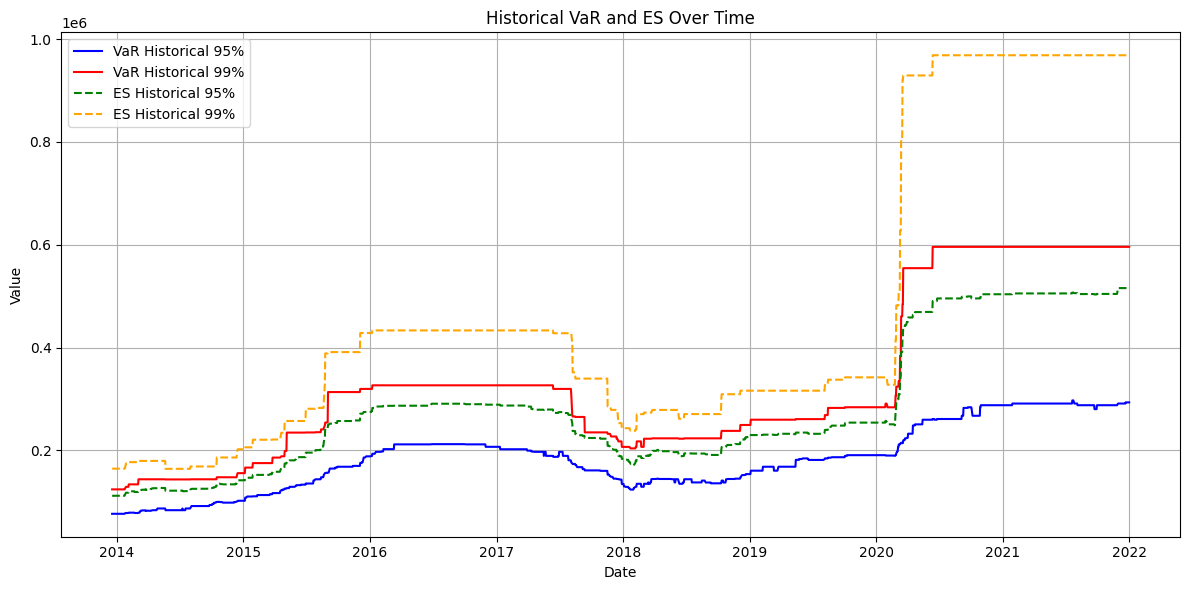

In [18]:
# Plot Historical VaR and ES over time
plt.figure(figsize=(12, 6))

# Extract the values for different confidence levels from the arrays
var_95 = [row[0] for row in var_results_df['VaR Historical']]
var_99 = [row[1] for row in var_results_df['VaR Historical']]
es_95 = [row[0] for row in es_results_df['ES Historical']]
es_99 = [row[1] for row in es_results_df['ES Historical']]

# Plot VaR Historical 95% and 99%
plt.plot(var_results_df['Date'], var_95, label='VaR Historical 95%', color='blue')
plt.plot(var_results_df['Date'], var_99, label='VaR Historical 99%', color='red')

# Plot ES Historical 95% and 99%
plt.plot(es_results_df['Date'], es_95, label='ES Historical 95%', color='green', linestyle='--')
plt.plot(es_results_df['Date'], es_99, label='ES Historical 99%', color='orange', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Historical VaR and ES Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

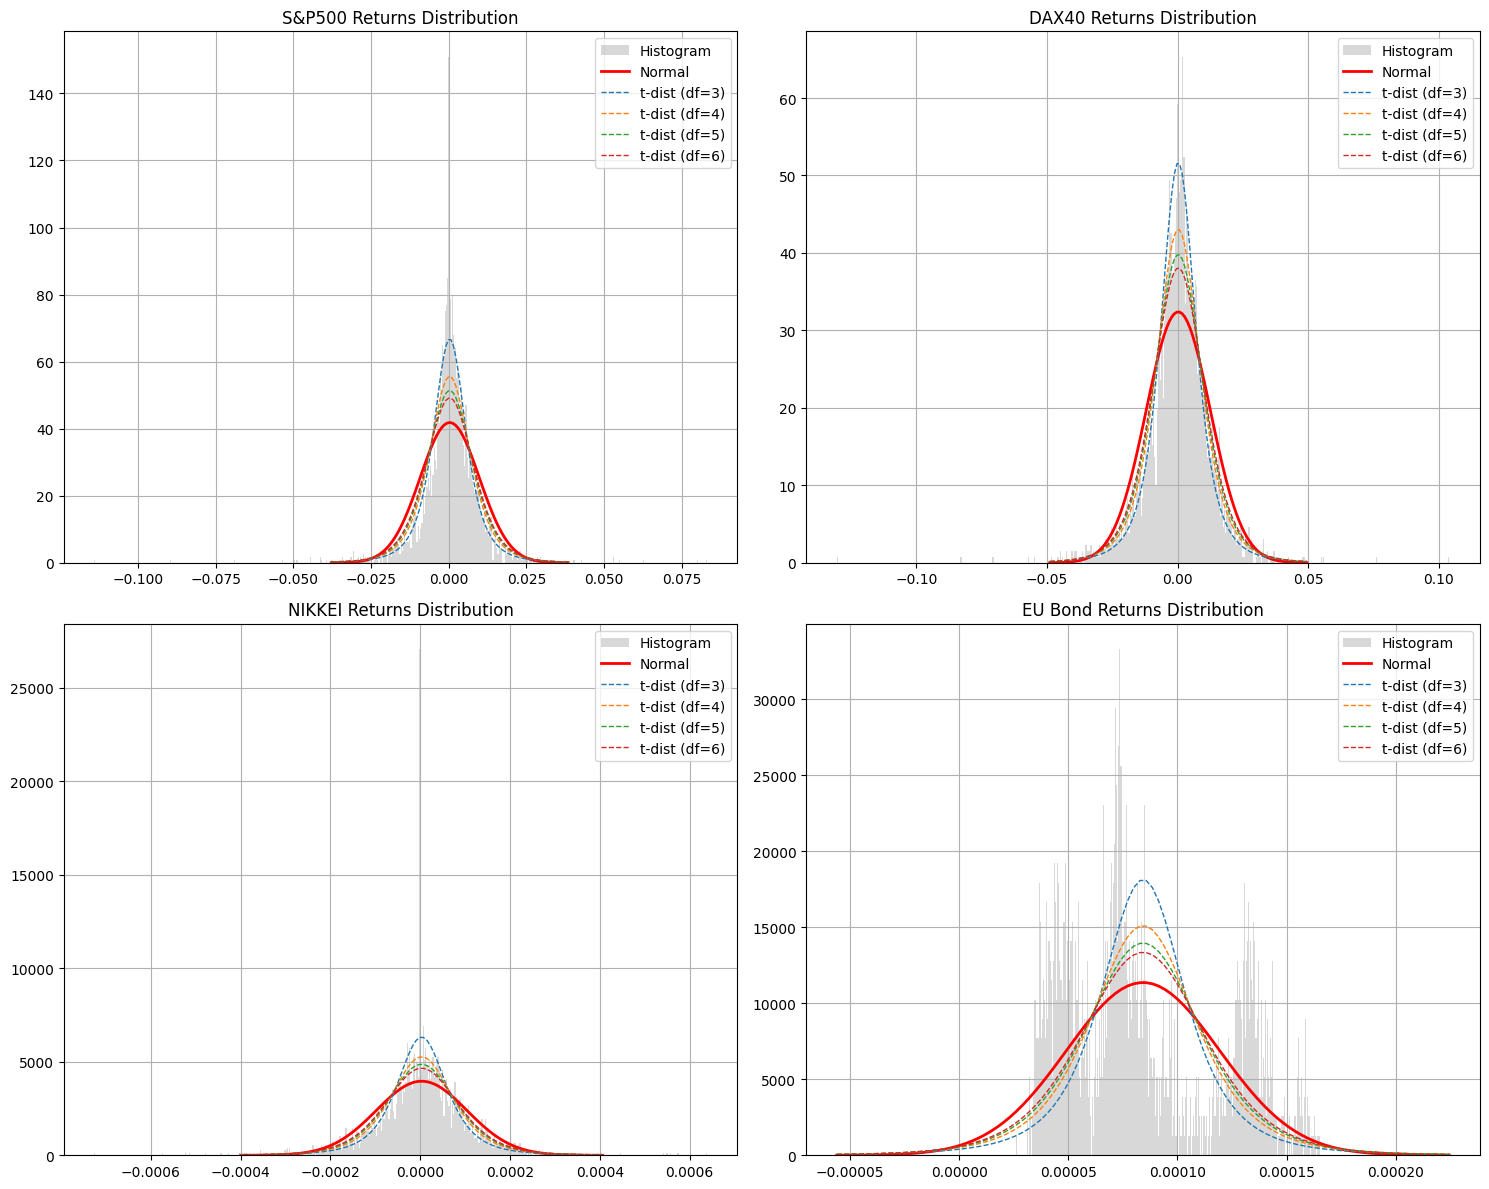

In [19]:
# Create subplots for all indices
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# S&P 500
sp500_returns = main_df['C_S&P500_Returns'].dropna()
mu_sp500 = sp500_returns.mean()
sigma_sp500 = sp500_returns.std()
x_sp500 = np.linspace(mu_sp500 - 4*sigma_sp500, mu_sp500 + 4*sigma_sp500, 100)
ax1.hist(sp500_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax1.plot(x_sp500, st.norm.pdf(x_sp500, mu_sp500, sigma_sp500), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_sp500 / np.sqrt(df/(df-2))
    ax1.plot(x_sp500, st.t.pdf((x_sp500-mu_sp500)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax1.set_title('S&P500 Returns Distribution')
ax1.legend()
ax1.grid(True)

# DAX40
dax_returns = main_df['C_Dax40_Returns'].dropna()
mu_dax = dax_returns.mean()
sigma_dax = dax_returns.std()
x_dax = np.linspace(mu_dax - 4*sigma_dax, mu_dax + 4*sigma_dax, 100)
ax2.hist(dax_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax2.plot(x_dax, st.norm.pdf(x_dax, mu_dax, sigma_dax), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_dax / np.sqrt(df/(df-2))
    ax2.plot(x_dax, st.t.pdf((x_dax-mu_dax)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax2.set_title('DAX40 Returns Distribution')
ax2.legend()
ax2.grid(True)

# NIKKEI
nikkei_returns = main_df['C_Nikkei_Returns'].dropna()
mu_nikkei = nikkei_returns.mean()
sigma_nikkei = nikkei_returns.std()
x_nikkei = np.linspace(mu_nikkei - 4*sigma_nikkei, mu_nikkei + 4*sigma_nikkei, 100)
ax3.hist(nikkei_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax3.plot(x_nikkei, st.norm.pdf(x_nikkei, mu_nikkei, sigma_nikkei), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_nikkei / np.sqrt(df/(df-2))
    ax3.plot(x_nikkei, st.t.pdf((x_nikkei-mu_nikkei)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax3.set_title('NIKKEI Returns Distribution')
ax3.legend()
ax3.grid(True)

# EU Bond
bond_returns = main_df['Interest_Bond_daily_rate'].dropna()
mu_bond = bond_returns.mean()
sigma_bond = bond_returns.std()
x_bond = np.linspace(mu_bond - 4*sigma_bond, mu_bond + 4*sigma_bond, 100)
ax4.hist(bond_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax4.plot(x_bond, st.norm.pdf(x_bond, mu_bond, sigma_bond), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_bond / np.sqrt(df/(df-2))
    ax4.plot(x_bond, st.t.pdf((x_bond-mu_bond)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax4.set_title('EU Bond Returns Distribution')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

## GARCH(1,1) with constant conditional correlation 

## EWMA

In [ ]:
def calculate_ewma_volatility(loss_series, lambda_=0.94):
    weights = (1 - lambda_) * (lambda_ ** np.arange(len(loss_series)-1, -1, -1))
    weighted_squared_losses = weights * (loss_series ** 2)
    ewma_variance = weighted_squared_losses.sum()
    return np.sqrt(ewma_variance)


In [ ]:
def calculate_ewma_vol_series(loss_series, lambda_=0.94):
    ewma_var = [loss_series.iloc[0] ** 2]  # Seed with squared first value
    for t in range(1, len(loss_series)):
        prev_var = ewma_var[-1]
        new_var = lambda_ * prev_var + (1 - lambda_) * (loss_series.iloc[t - 1] ** 2)
        ewma_var.append(new_var)
    return pd.Series(np.sqrt(ewma_var), index=loss_series.index)


In [ ]:
def main_ewma():
    # Initialize lists to store results
    mean_losses = []
    portfolio_std_losses = []
    ewma_vol_94 = []  # For λ = 0.94
    ewma_vol_97 = []  # For λ = 0.97
    VaR_results = []
    ES_results = []

    time_window = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]
    vAlpha = np.array([0.95, 0.99])
    sample_size = 500
    degrees_of_freedom = [0, 3, 4, 5, 6]

    fhs_results = []


    for i in range(sample_size, len(time_window)):
        window = time_window.iloc[i - sample_size:i]
        current_date = time_window.iloc[i]['Date']
        
        loss_stats = calculate_daily_loss_variables(window, current_date)
        mean_loss = loss_stats["Portfolio_mean_loss"]
        std_loss = loss_stats["Portfolio_std_loss"]
        
        # Calculate EWMA volatilities for both lambda values
        ewma_94 = calculate_ewma_volatility(window['Portfolio_loss'], lambda_=0.94)
        ewma_97 = calculate_ewma_volatility(window['Portfolio_loss'], lambda_=0.97)

        # --- Filtered Historical Simulation (FHS) using EWMA filtered losses ---
        factors = ['C_S&P500_Loss', 'C_Dax40_Loss', 'C_Nikkei_Loss', 'Interest_Bond_Loss']
        filtered_losses = []

        for factor in factors:
            series = window[factor]
            vol_series = calculate_ewma_vol_series(series, lambda_=0.94)
            current_vol = vol_series.iloc[-1]

            normalized = series / vol_series
            normalized = normalized.replace([np.inf, -np.inf], 0).fillna(0)

            filtered = normalized * current_vol
            filtered_losses.append(filtered)

        # Combine into filtered portfolio loss
        filtered_portfolio_loss = np.sum(filtered_losses, axis=0)

        # Calculate FHS VaR and ES
        FHS_VaR_95 = np.percentile(filtered_portfolio_loss, 5)
        FHS_VaR_99 = np.percentile(filtered_portfolio_loss, 1)
        FHS_ES_95 = filtered_portfolio_loss[filtered_portfolio_loss <= FHS_VaR_95].mean()
        FHS_ES_99 = filtered_portfolio_loss[filtered_portfolio_loss <= FHS_VaR_99].mean()

        # Store results
        fhs_results.append({
            'Date': current_date,
            'FHS_VaR_95': FHS_VaR_95,
            'FHS_VaR_99': FHS_VaR_99,
            'FHS_ES_95': FHS_ES_95,
            'FHS_ES_99': FHS_ES_99
        })

        
        # Append everything
        mean_losses.append(mean_loss)
        portfolio_std_losses.append(std_loss)
        ewma_vol_94.append(ewma_94)
        ewma_vol_97.append(ewma_97)
        
        var_row = {'Date': current_date}
        es_row = {'Date': current_date}
        
        for df in degrees_of_freedom:
            current_var = VaR(vAlpha, mean_loss, std_loss, df)
            current_es = ES(vAlpha, mean_loss, std_loss, df)
            
            var_key = f"VaR {'Normal' if df == 0 else f'T{df}'}"
            es_key = f"ES {'Normal' if df == 0 else f'T{df}'}"
            var_row[var_key] = current_var
            es_row[es_key] = current_es

        # Historical simulation
        # Extract the portfolio loss values from the window
        historical_losses = window['Portfolio_loss'].dropna()  # Remove NaN values directly
        
        # Sort the losses in ascending order
        sorted_losses = np.sort(historical_losses)

        # Calculate VaR for alpha levels
        var_95 = np.percentile(sorted_losses, 95) 
        var_99 = np.percentile(sorted_losses, 99)  

        # Calculate ES
        es_95 = sorted_losses[sorted_losses >= var_95].mean()  # Mean of losses below VaR 95
        es_99 = sorted_losses[sorted_losses >= var_99].mean()  # Mean of losses below VaR 99

        # Add to the row dictionaries
        var_row['VaR Historical'] = [var_95, var_99]
        es_row['ES Historical'] = [es_95, es_99]
        
        VaR_results.append(var_row)
        ES_results.append(es_row)

    # Final DataFrames
    mean_losses_df = pd.DataFrame(mean_losses, columns=['Mean_Loss'])
    portfolio_std_losses_df = pd.DataFrame(portfolio_std_losses, columns=['Std_Loss'])
    ewma_94_df = pd.DataFrame(ewma_vol_94, columns=['EWMA_0.94'])
    ewma_97_df = pd.DataFrame(ewma_vol_97, columns=['EWMA_0.97'])
    var_results_df = pd.DataFrame(VaR_results)
    es_results_df = pd.DataFrame(ES_results)
    fhs_df = pd.DataFrame(fhs_results)


    return mean_losses_df, portfolio_std_losses_df, ewma_94_df, ewma_97_df, var_results_df, es_results_df, fhs_df 


/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/673492452.py:51: RuntimeWarning: Mean of empty slice.
  FHS_ES_95 = filtered_portfolio_loss[filtered_portfolio_loss <= FHS_VaR_95].mean()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/673492452.py:52: RuntimeWarning: Mean of empty slice.
  FHS_ES_99 = filtered_portfolio_loss[filtered_portfolio_loss <= FHS_VaR_99].mean()


Mean Loss Results Head:


,Mean_Loss
0,-192.824238
1,-192.346281
2,-192.259451
3,-192.319473
4,-192.027996



Portfolio Std Loss Results Head:


,Std_Loss
0,118.756581
1,119.654655
2,119.656496
3,119.677994
4,119.997366



FHS Results Head:


,Date,FHS_VaR_95,FHS_VaR_99,FHS_ES_95,FHS_ES_99
0,2015-12-03,NaN,NaN,NaN,NaN
1,2015-12-04,382.290918,495.179825,466.460397,613.023522
2,2015-12-07,436.724060,577.921030,527.729499,663.844445
3,2015-12-08,430.184267,570.693385,520.129741,652.007013
4,2015-12-09,418.018378,538.287576,503.539788,623.906461



VaR Results Head:


,EWMA_0.94
0,204.933907
1,210.608780
2,207.315729
3,211.233658
4,205.851081



ES Results Head:


,EWMA_0.97
0,216.293872
1,218.674555
2,216.856087
3,218.460714
4,215.660440



EWMA Volatility Results Head:


,Date,VaR Normal,VaR T3,VaR T4,VaR T5,VaR T6
0,2015-12-03,"[2.5129557625034806, 83.44488271228627]","[-31.467887853444324, 118.50516774627911]","[-13.805422635742161, 121.82036330433138]","[-7.463056488013734, 116.71046505557118]","[-4.405039270274443, 111.90253798950678]"
1,2015-12-04,"[4.468112381100269, 86.01207150668895]","[-29.76970484758371, 121.33749322211835]","[-11.973670624117062, 124.67775931076451]","[-5.583341548784574, 119.5292184365139]","[-2.5021986623263217, 114.68493234411389]"
2,2015-12-07,"[4.557970530093883, 86.10318416601493]","[-29.680373429152723, 121.42914934422205]","[-11.884065423188304, 124.76946682108095]","[-5.493638036050271, 119.62084673927419]","[-2.412447747851587, 114.77648612011555]"
3,2015-12-08,"[4.533309711388881, 86.09317406856707]","[-29.711185638126835, 121.42548604318188]","[-11.911680280210362, 124.76640365410236]","[-5.520104764737255, 119.61685855175404]","[-2.4383608982469696, 114.7716275764588]"
4,2015-12-09,"[5.350107627536346, 87.12762243948526]","[-28.985772498608924, 122.55422213551782]","[-11.138767424178951, 125.90405531101283]","[-4.730135365900026, 120.74076814518486]","[-1.6401675652564052, 115.88260719834597]"


,Date,ES Normal,ES T3,ES T4,ES T5,ES T6
0,2015-12-03,"[52.13648350391358, 123.68749151202982]","[72.81159896098345, 287.3360887173585]","[76.13226886170636, 245.56692736832358]","[73.03425106672685, 216.74782534497658]","[70.02074483678322, 198.1871576985208]"
1,2015-12-04,"[54.46690853387028, 126.55900731744131]","[75.29837558635043, 291.4451656533397]","[78.64415741633374, 249.36013303241603]","[75.52271145594162, 220.32309207716807]","[72.48641616308757, 201.62206294134458]"
2,2015-12-07,"[54.5575358876836, 126.65074376975528]","[75.38932342117712, 291.53943879128315]","[78.73515672422994, 249.45375871457216]","[75.61366274205605, 220.41627103993156]","[72.5773207374178, 201.71495419874603]"
3,2015-12-08,"[54.54185817984887, 126.648018600103]","[75.37738843101812, 291.56633814772516]","[78.72382285912664, 249.47309679868147]","[75.60176805754719, 220.43039213926687]","[72.5648805322295, 201.72571534882178]"
4,2015-12-09,"[55.492108786267124, 127.79069153006157]","[76.38324068256293, 293.1491117023288]","[79.73860539741088, 250.94354043225593]","[76.60821908801518, 221.82333248213934]","[73.56322733206662, 203.0687404369072]"


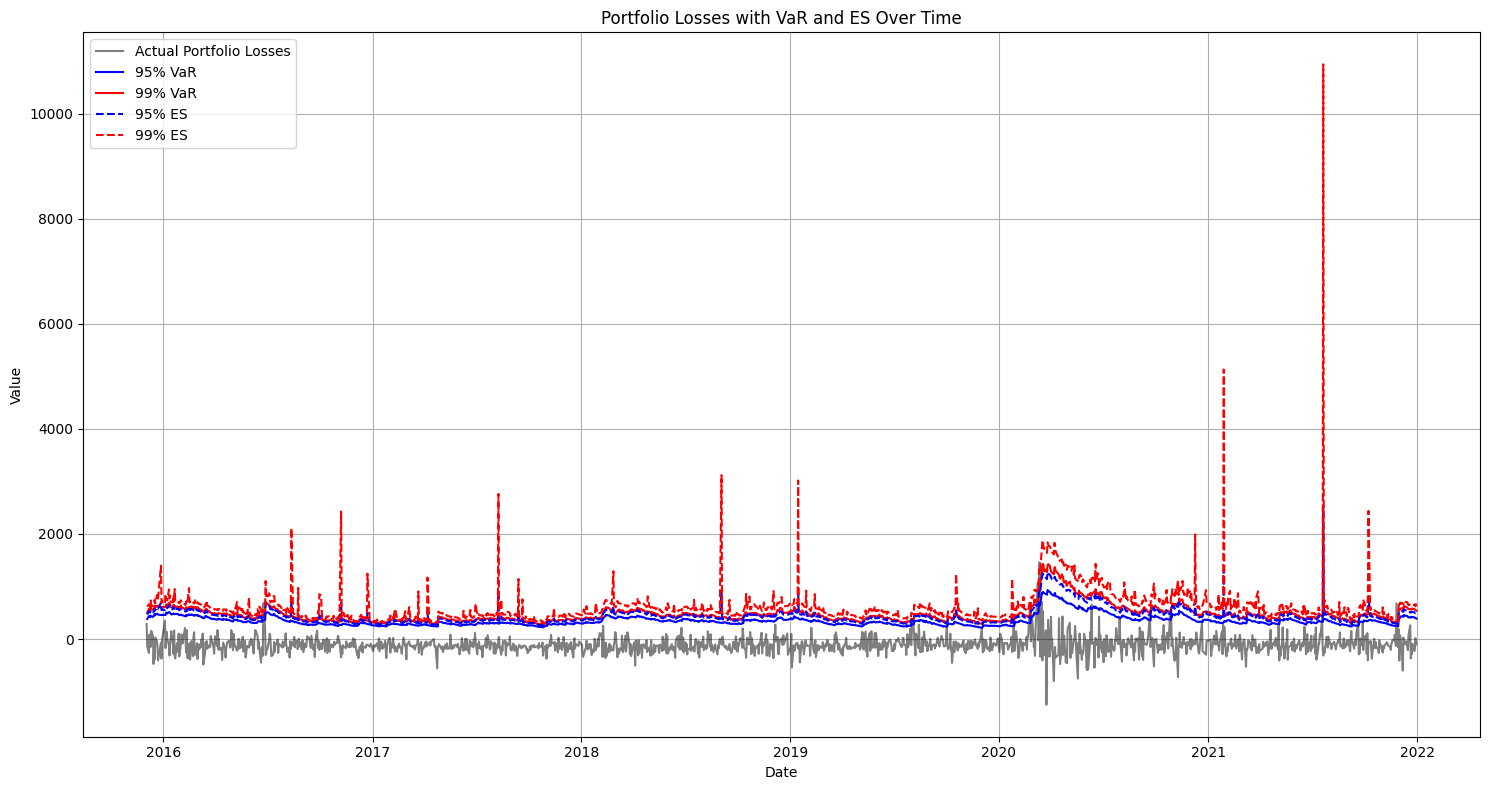

In [ ]:
# Unpack the returned DataFrames
mean_loss_df, portfolio_std_losses_df, var_results_df, es_results_df, ewma_94_df, ewma_97_df, fhs_df  = main_ewma()

fhs_df[['FHS_VaR_95', 'FHS_VaR_99', 'FHS_ES_95', 'FHS_ES_99']] = fhs_df[
    ['FHS_VaR_95', 'FHS_VaR_99', 'FHS_ES_95', 'FHS_ES_99']].abs()


# Display the results

print("Mean Loss Results Head:")
display(mean_loss_df.head())
print("\nPortfolio Std Loss Results Head:")
display(portfolio_std_losses_df.head())
print("\nFHS Results Head:")
display(fhs_df.head())
print("\nVaR Results Head:")
display(var_results_df.head())
print("\nES Results Head:")
display(es_results_df.head())
print("\nEWMA Volatility Results Head:")
display(ewma_94_df.head())
display(ewma_97_df.head())

# Extract the actual losses aligned with fhs_df
aligned_losses = main_df.loc[main_df['Date'].isin(fhs_df['Date']), 'Portfolio_loss'].values

# Create a figure for comparing VaR, ES and actual portfolio losses
fig, ax = plt.subplots(figsize=(15, 8))

# Plot actual portfolio losses
ax.plot(fhs_df['Date'], aligned_losses, label='Actual Portfolio Losses', color='black', alpha=0.5)


# Plot VaR values
ax.plot(fhs_df['Date'], fhs_df['FHS_VaR_95'], label='95% VaR', color='blue')
ax.plot(fhs_df['Date'], fhs_df['FHS_VaR_99'], label='99% VaR', color='red')

# Plot ES values
ax.plot(fhs_df['Date'], fhs_df['FHS_ES_95'], label='95% ES', color='blue', linestyle='--')
ax.plot(fhs_df['Date'], fhs_df['FHS_ES_99'], label='99% ES', color='red', linestyle='--')

# Customize the plot
ax.set_title('Portfolio Losses with VaR and ES Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.optimize import minimize

#maximum likelihood estimation of GARCH(1,1) parameters
def garch_likelihood(params, returns):
    omega, alpha, beta = params
    T = len(returns)
    var = np.zeros(T)
    var[0] = omega / (1 - alpha - beta)
    ll = 0
    for t in range(2, T):
        var[t] = omega + alpha * returns[t-1]**2 + beta * var[t-1]
        ll += 0.5 * (np.log(2 * np.pi) + np.log(var[t]) + returns[t]**2 / var[t])
    return ll


In [ ]:
# GARCH(1,1) parameter estimation using MLE
# This function estimates the parameters of a GARCH(1,1) model using maximum likelihood estimation (MLE).
def parameter_estimation_GARCH(returns):
    # Run the optimization
    result = minimize(
        garch_likelihood,
        x0=[0.00002, 0.05, 0.9],
        args=(returns,),
        method='SLSQP',
        bounds=[(1e-6, None), (0, 0.99), (0, 0.99)],
        constraints=[
            {'type': 'ineq', 'fun': lambda x: 0.999 - x[1] - x[2]}
        ],
        options={'disp': True}
    )

    # Return the optimization result
    return result

# # Check the optimization result
# if result.success:
#     print(f"Optimized parameters: omega={result.x[0]}, alpha={result.x[1]}, beta={result.x[2]}")
# else:
#     print("Optimization failed:", result.message)


In [ ]:
# calculate the GARCH(1,1) volatility for returns t
def garch_volatility(returns):
    param = parameter_estimation_GARCH(returns)
    omega, alpha, beta = param.x
    T = len(returns)
    var = np.zeros(T)
    var[0]= param.x[0] / (1 - param.x[1] - param.x[2])
    for t in range(2, T):
        var[t] = omega + alpha * returns[t-1]**2 + beta * var[t-1]
    return np.sqrt(var)

In [ ]:
# calculate correlation matrix of the 4 time series
# the method must take the returns as matrix of 4 vectors and return the correlation matrix
def correlation_matrix(returns):
    # Calculate the covariance matrix
    cov_matrix = np.cov(returns.T)
    
    # Calculate the standard deviations of each asset
    std_devs = np.sqrt(np.diag(cov_matrix))
    
    # Calculate the correlation matrix
    corr_matrix = cov_matrix / np.outer(std_devs, std_devs)
    
    return corr_matrix


In [ ]:
# calculate the diagonal matrix with the garch volatility of the 4 time series
def diagonal_matrix(returns):
    # Initialize an empty dictionary to store volatilities for each column
    volatilities_dict = {}

    # Iterate through each column in the returns DataFrame
    for column in returns.columns:
        # Reset the index of the column to ensure numeric indexing
        column_returns = returns[column].dropna().reset_index(drop=True)
        
        # Calculate the GARCH(1,1) volatility for the column
        volatilities_dict[column] = garch_volatility(column_returns)
        
    # Combine the volatilities into a single array
    volatilities = np.array([vol[-1] for vol in volatilities_dict.values()])

    # Create a diagonal matrix with the volatilities
    #diag_matrix = np.diag(volatilities)
    
    return volatilities

In [ ]:
# calculate the covariance matrix of the 4 time series
def covariance_matrix(returns):
    # Calculate the GARCH(1,1) volatilities
    volatilities = diagonal_matrix(returns)
    
    # Calculate the correlation matrix
    corr_matrix = correlation_matrix(returns)
    
    # Calculate the covariance matrix
    cov_matrix = np.outer(volatilities, volatilities) * corr_matrix
    
    return cov_matrix

In [ ]:
# method to calculate the portfolio variance and volatility
def portfolio_variance(weights, cov_matrix):
    # Calculate the portfolio variance
    port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    
    # Calculate the portfolio volatility
    port_volatility = np.sqrt(port_variance)
    
    return port_variance, port_volatility

In [ ]:
# method to calculate the VaR and ES of the portfolio using the normal distribution
def portfolio_VaR_ES(weights, cov_matrix, alpha=0.95):
    # Calculate the portfolio variance and volatility
    _, port_volatility = portfolio_variance(weights, cov_matrix)
    
    # Calculate the VaR using the normal distribution
    VaR = -port_volatility * st.norm.ppf(1 - alpha)
    
    # Calculate the ES using the normal distribution
    ES = -port_volatility * (st.norm.pdf(st.norm.ppf(1 - alpha)) / (1 - alpha))
    
    return VaR, ES

In [ ]:
# main function to run the analysis
def main_analysis(time_window_size):
    # Initialize lists to store results
    portfolio_VaR_list = []
    portfolio_ES_list = []
    dates = []

    # Iterate through the dataset with a rolling time window
    for i in range(time_window_size, len(main_df)):
        # Extract the rolling time window
        window = main_df.iloc[i - time_window_size:i]
        current_date = main_df.iloc[i]['Date']
        
        # Calculate the returns for each asset in the window
        returns = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].dropna()

        # Define the weights for the portfolio
        weights = np.array([0.4, 0.3, 0.15, 0.15])

        # Calculate the covariance matrix
        cov_matrix = covariance_matrix(returns)

        # Calculate the portfolio VaR and ES
        VaR, ES = portfolio_VaR_ES(weights, cov_matrix)

        # Append results
        portfolio_VaR_list.append(VaR)
        portfolio_ES_list.append(ES)
        dates.append(current_date)

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Date': dates,
        'Portfolio VaR': portfolio_VaR_list,
        'Portfolio ES': portfolio_ES_list
    })

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Date'], results_df['Portfolio VaR'], label='Portfolio VaR', color='red')
    plt.plot(results_df['Date'], results_df['Portfolio ES'], label='Portfolio ES', color='blue')
    plt.title('Portfolio VaR and ES Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()

    return results_df

time_window_size = 500

main_analysis(time_window_size)

In [ ]:
# show only the column names and the first 3 rows of the main dataframe
print(main_df.columns)
print(main_df.head(3))


In [ ]:
# checking assumption on taking mean = 0 
# Calculate portfolio daily returns
main_df['Portfolio_Daily_Returns'] = (
    weights['S&P500'] * main_df['C_S&P500_Returns'] +
    weights['DAX40'] * main_df['C_Dax40_Returns'] +
    weights['NIKKEI'] * main_df['C_Nikkei_Returns'] +
    weights['EU-BOND'] * main_df['Interest_Bond_daily_rate']
)

# make a graph of the portfolio daily returns
plt.figure(figsize=(12, 6))
plt.plot(main_df['Date'], main_df['Portfolio_Daily_Returns'], label='Portfolio Daily Returns', color='blue')
plt.title('Portfolio Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid()
#plt.show()

# Calculate the mean of the returns for each stock over a subset of the data defined on the time range
# Define the sample size
sample_size = 500

# Initialize variables to store the mean returns for each stock for each time window
mean_sp500_returns_list = []
mean_dax40_returns_list = []
mean_nikkei_returns_list = []
mean_eu_bond_returns_list = []

# Loop through the data with a fixed sample size
for i in range(sample_size, len(main_df)):
    time_range_start = main_df['Date'].iloc[i - sample_size]
    time_range_end = main_df['Date'].iloc[i]
    time_range_df = main_df[(main_df['Date'] >= time_range_start) & (main_df['Date'] <= time_range_end)]
    
    # Calculate mean returns for each stock
    mean_sp500_returns = time_range_df['C_S&P500_Returns'].mean()
    mean_dax40_returns = time_range_df['C_Dax40_Returns'].mean()
    mean_nikkei_returns = time_range_df['C_Nikkei_Returns'].mean()
    mean_eu_bond_returns = time_range_df['Interest_Bond_daily_rate'].mean()
    
    # Append the results to the respective lists
    mean_sp500_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean S&P500 Returns': mean_sp500_returns
    })
    mean_dax40_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean DAX40 Returns': mean_dax40_returns
    })
    mean_nikkei_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean Nikkei Returns': mean_nikkei_returns
    })
    mean_eu_bond_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean EU Bond Returns': mean_eu_bond_returns
    })

# Convert the results to DataFrames for easier analysis
mean_sp500_returns_df = pd.DataFrame(mean_sp500_returns_list)
mean_dax40_returns_df = pd.DataFrame(mean_dax40_returns_list)
mean_nikkei_returns_df = pd.DataFrame(mean_nikkei_returns_list)
mean_eu_bond_returns_df = pd.DataFrame(mean_eu_bond_returns_list)

# Display the results
display(mean_sp500_returns_df.head())
display(mean_dax40_returns_df.head())
display(mean_nikkei_returns_df.head())
display(mean_eu_bond_returns_df.head())

# Plot the mean returns for each stock over time
plt.figure(figsize=(12, 6))
plt.plot(mean_sp500_returns_df['End Date'], mean_sp500_returns_df['Mean S&P500 Returns'], label='Mean S&P500 Returns', color='blue')
plt.plot(mean_dax40_returns_df['End Date'], mean_dax40_returns_df['Mean DAX40 Returns'], label='Mean DAX40 Returns', color='orange')
plt.plot(mean_nikkei_returns_df['End Date'], mean_nikkei_returns_df['Mean Nikkei Returns'], label='Mean Nikkei Returns', color='green')
plt.plot(mean_eu_bond_returns_df['End Date'], mean_eu_bond_returns_df['Mean EU Bond Returns'], label='Mean EU Bond Returns', color='red')
plt.title('Mean Returns Over Time for Each Stock')
plt.xlabel('End Date')
plt.ylabel('Mean Returns')
plt.legend()
plt.grid()
plt.show()

# Backtesting VaR and ES

In this section, we perform backtesting on the calculated Value at Risk (VaR) and Expected Shortfall (ES) measures. Backtesting helps assess the accuracy and reliability of the risk models.

We will:
1.  **Calculate Violations:** Identify the days where the actual portfolio loss exceeded the predicted VaR.
2.  **Compare Actual vs. Expected Violations (VaR):** Group violations by year and compare the observed number of violations against the number expected based on the confidence level (alpha).
3.  **Compare Actual Shortfall vs. Predicted ES (ES):** For the days a violation occurred, compare the average actual loss (shortfall) against the predicted ES, grouped by year.
4.  **Visualize Violations:** Plot the occurrences of violations over time to visually inspect for clustering or patterns.

In [23]:
def calculate_violations(actual_losses, var_predictions):
    """Checks for VaR violations."""
    return actual_losses > var_predictions

def backtest_var(violations, alpha, dates):
    """Compares actual vs. expected VaR violations yearly."""
    if not isinstance(violations, pd.Series):
        violations = pd.Series(violations, index=dates)
    elif violations.index.name != 'Date': # Ensure index is Date for grouping
         violations = violations.set_index(dates)
            
    violations_df = pd.DataFrame({'Violations': violations, 'Year': violations.index.year})
    yearly_violations = violations_df.groupby('Year')['Violations'].sum()
    yearly_counts = violations_df.groupby('Year')['Violations'].count()
    
    expected_violations = yearly_counts * (1 - alpha)
    
    summary = pd.DataFrame({
        'Actual Violations': yearly_violations,
        'Expected Violations': expected_violations,
        'Total Observations': yearly_counts
    })
    return summary

def backtest_es(actual_losses, violations, es_predictions, dates):
    """Compares actual average shortfall vs. predicted ES yearly."""
    # Ensure inputs are pandas Series with Date index
    if not isinstance(actual_losses, pd.Series):
        actual_losses = pd.Series(actual_losses, index=dates)
    elif actual_losses.index.name != 'Date':
        actual_losses = actual_losses.set_index(dates)
        
    if not isinstance(violations, pd.Series):
        violations = pd.Series(violations, index=dates)
    elif violations.index.name != 'Date':
        violations = violations.set_index(dates)
        
    if not isinstance(es_predictions, pd.Series):
        es_predictions = pd.Series(es_predictions, index=dates)
    elif es_predictions.index.name != 'Date':
        es_predictions = es_predictions.set_index(dates)

    results_df = pd.DataFrame({
        'Actual_Loss': actual_losses,
        'Violation': violations,
        'Predicted_ES': es_predictions,
        'Year': actual_losses.index.year
    })
    
    # Filter for violations
    violation_data = results_df[results_df['Violation']]
    
    # Calculate yearly averages
    yearly_avg_actual_shortfall = violation_data.groupby('Year')['Actual_Loss'].mean()
    yearly_avg_predicted_es = violation_data.groupby('Year')['Predicted_ES'].mean()
    yearly_violation_count = violation_data.groupby('Year').size()

    summary = pd.DataFrame({
        'Avg Actual Shortfall': yearly_avg_actual_shortfall,
        'Avg Predicted ES': yearly_avg_predicted_es,
        'Violation Count': yearly_violation_count
    })
    return summary

def plot_violations(violations, dates, title):
    """Plots VaR violations over time."""
    plt.figure(figsize=(15, 4))
    plt.plot(dates, violations, 'ro', markersize=4, alpha=0.7, label='Violation')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Violation (1=Yes, 0=No)')
    plt.yticks([0, 1])
    plt.grid(axis='y', linestyle='--')
    plt.show()

def run_backtesting(main_df, var_results_df, es_results_df):
    """Runs the backtesting process for VaR and ES models."""
    # Align main_df with var/es results (which start after the initial window)
    backtest_dates = var_results_df['Date']
    backtest_data = main_df[main_df['Date'].isin(backtest_dates)].set_index('Date')
    actual_losses = backtest_data['Portfolio_loss']

    # Confidence levels used
    alphas = [0.95, 0.99]
    alpha_indices = {0.95: 0, 0.99: 1} # Index mapping for results arrays

    # Iterate through models (columns in var_results_df/es_results_df)
    var_model_cols = [col for col in var_results_df.columns if col != 'Date']
    es_model_cols = [col for col in es_results_df.columns if col != 'Date']

    for i, model_name in enumerate(var_model_cols):
        print(f"\n--- Backtesting for Model: {model_name} ---")
        
        # Extract predictions for this model
        # Need to handle the fact that predictions are stored as arrays [pred_95, pred_99]
        var_preds_list = var_results_df[model_name].tolist()
        # Ensure alignment between var and es model columns
        if i < len(es_model_cols):
            es_preds_list = es_results_df[es_model_cols[i]].tolist()
        else:
            print(f"  Warning: No matching ES column found for {model_name}. Skipping ES backtest.")
            es_preds_list = None
        
        for alpha in alphas:
            alpha_idx = alpha_indices[alpha]
            print(f"\nConfidence Level: {alpha*100}%")
            
            # Extract predictions for the specific alpha
            # Handle potential errors if data isn't as expected (e.g., not a list/array)
            try:
                var_predictions = pd.Series([p[alpha_idx] for p in var_preds_list], index=backtest_dates)
                if es_preds_list:
                    es_predictions = pd.Series([p[alpha_idx] for p in es_preds_list], index=backtest_dates)
                else:
                    es_predictions = None
            except (TypeError, IndexError) as e:
                print(f"  Error extracting predictions for alpha={alpha}: {e}. Skipping.")
                continue
                
            # 1. Calculate Violations
            violations = calculate_violations(actual_losses, var_predictions)
            
            # 2. Backtest VaR
            var_summary = backtest_var(violations, alpha, backtest_dates)
            print("\nVaR Backtest Summary (Yearly):")
            display(var_summary)
            
            # 3. Backtest ES
            if es_predictions is not None:
                es_summary = backtest_es(actual_losses, violations, es_predictions, backtest_dates)
                print("\nES Backtest Summary (Yearly):")
                display(es_summary)
            
            # 4. Plot Violations
            plot_violations(violations, backtest_dates, f'VaR Violations for {model_name} (alpha={alpha})')


--- Backtesting for Model: VaR Normal ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.400000,8
2014,28,12.750000,255
2015,39,12.700000,254
2016,9,12.850000,257
2017,3,12.750000,255
2018,30,12.650000,253
2019,16,12.650000,253
2020,24,12.750000,255
2021,4,12.850000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,127474.407200,111767.637767,28
2015,225762.168766,168969.121485,39
2016,245764.980182,240621.060542,9
2017,220400.343617,229231.334456,3
2018,202672.170657,168957.476526,30
2019,231804.299531,195423.033116,16
2020,500355.791430,285335.866458,24
2021,388888.445135,377548.697478,4


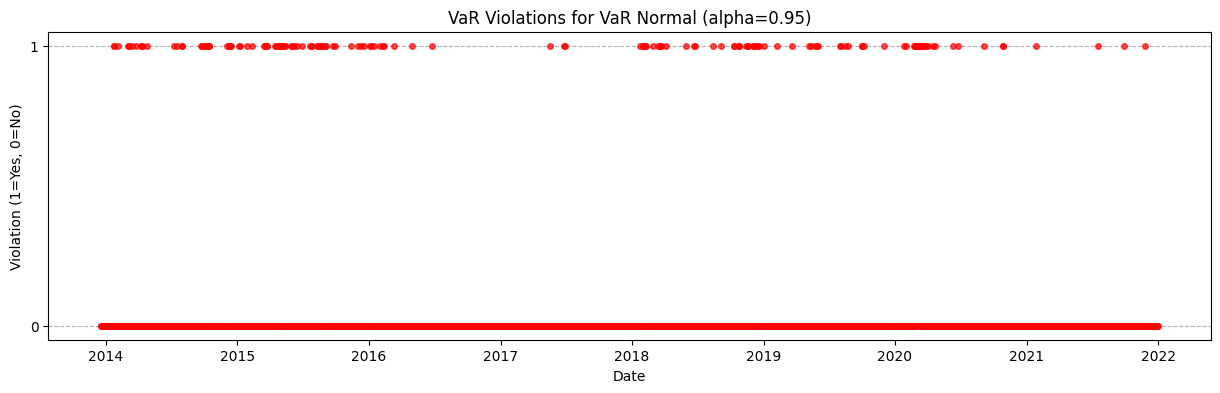


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.080000,8
2014,10,2.550000,255
2015,24,2.540000,254
2016,3,2.570000,257
2017,0,2.550000,255
2018,15,2.530000,253
2019,8,2.530000,253
2020,15,2.550000,255
2021,1,2.570000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,163809.679720,142557.075727,10
2015,269131.467358,219035.041595,24
2016,309092.413225,310446.981960,3
2018,248676.621431,219674.530797,15
2019,273539.484965,250898.011460,8
2020,612483.145870,349191.650221,15
2021,575601.041257,490903.376876,1


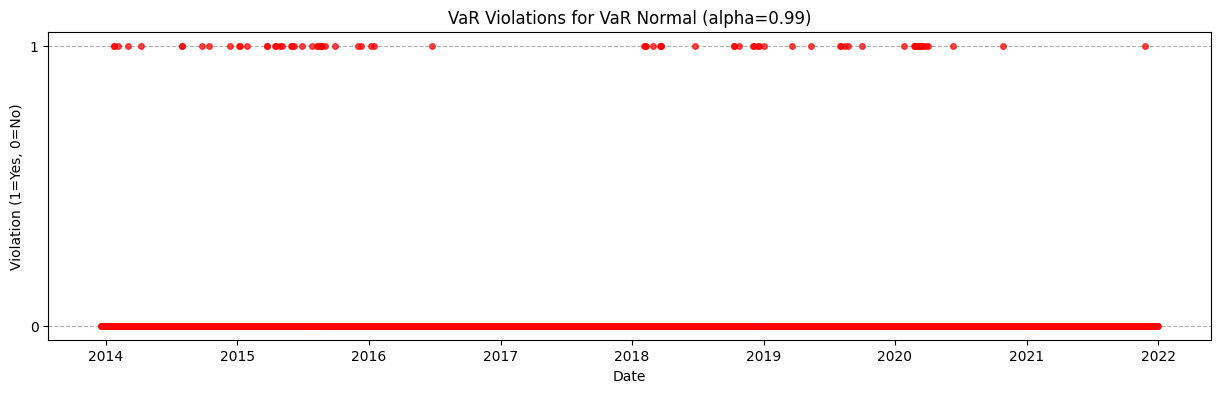


--- Backtesting for Model: VaR T3 ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.400000,8
2014,38,12.750000,255
2015,47,12.700000,254
2016,15,12.850000,257
2017,10,12.750000,255
2018,34,12.650000,253
2019,22,12.650000,253
2020,29,12.750000,255
2021,10,12.850000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,114189.456010,121541.755054,38
2015,210029.107433,186313.350633,47
2016,217712.436703,264131.938142,15
2017,166124.681649,230476.443738,10
2018,192421.406001,183427.581976,34
2019,203754.879000,210649.600191,22
2020,456403.407772,317179.345822,29
2021,320163.860728,411187.313445,10


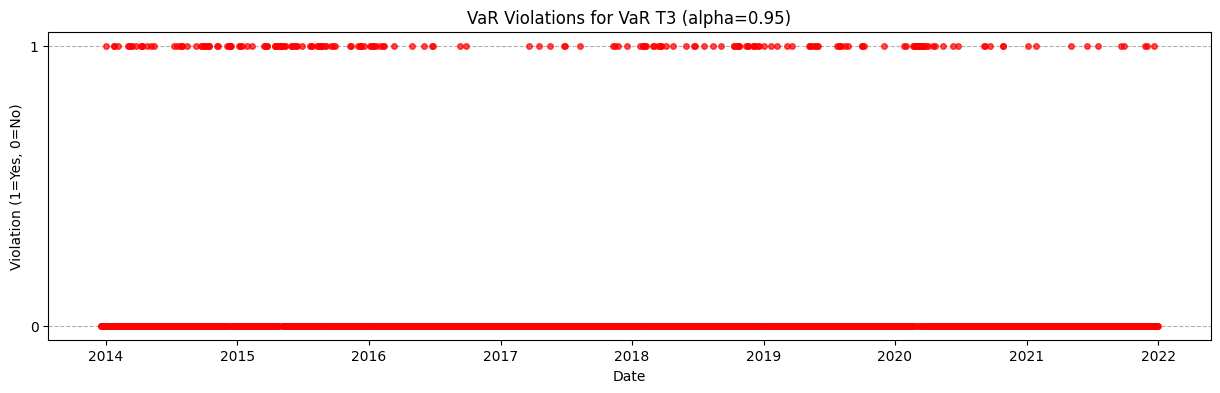


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.080000,8
2014,7,2.550000,255
2015,17,2.540000,254
2016,1,2.570000,257
2017,0,2.550000,255
2018,9,2.530000,253
2019,5,2.530000,253
2020,13,2.550000,255
2021,1,2.570000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,179775.777259,219689.885288,7
2015,297575.746271,337575.399306,17
2016,351547.269932,457831.697688,1
2018,278426.553697,329957.215092,9
2019,297005.549830,381554.384084,5
2020,641228.124603,505164.674579,13
2021,575601.041257,748608.598544,1


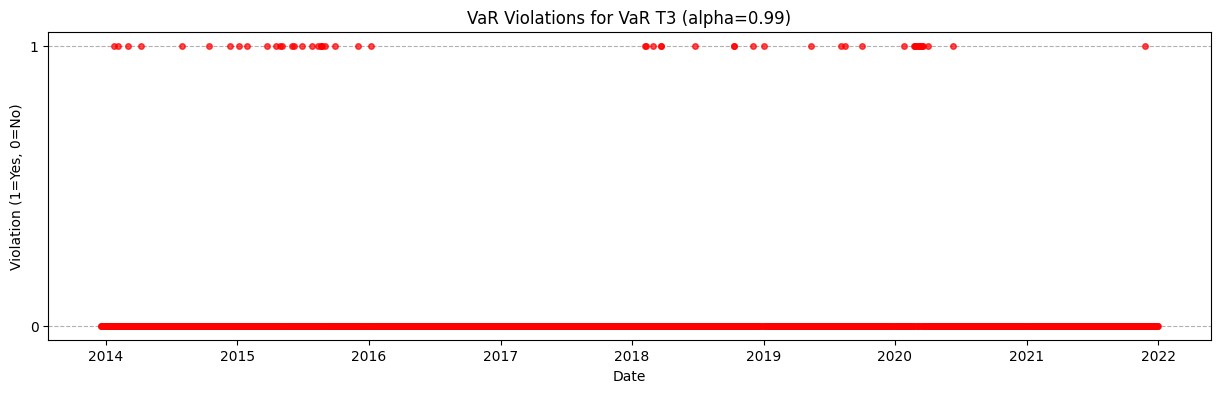


--- Backtesting for Model: VaR T4 ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.400000,8
2014,29,12.750000,255
2015,43,12.700000,254
2016,12,12.850000,257
2017,6,12.750000,255
2018,31,12.650000,253
2019,16,12.650000,253
2020,28,12.750000,255
2021,7,12.850000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,125831.123347,123015.472574,29
2015,218958.583471,189463.016559,43
2016,228935.696250,264442.475631,12
2017,189640.033713,244477.176118,6
2018,200130.746744,185715.977426,31
2019,231804.299531,214744.393933,16
2020,464847.993359,320046.944232,28
2021,343431.308700,415965.844953,7


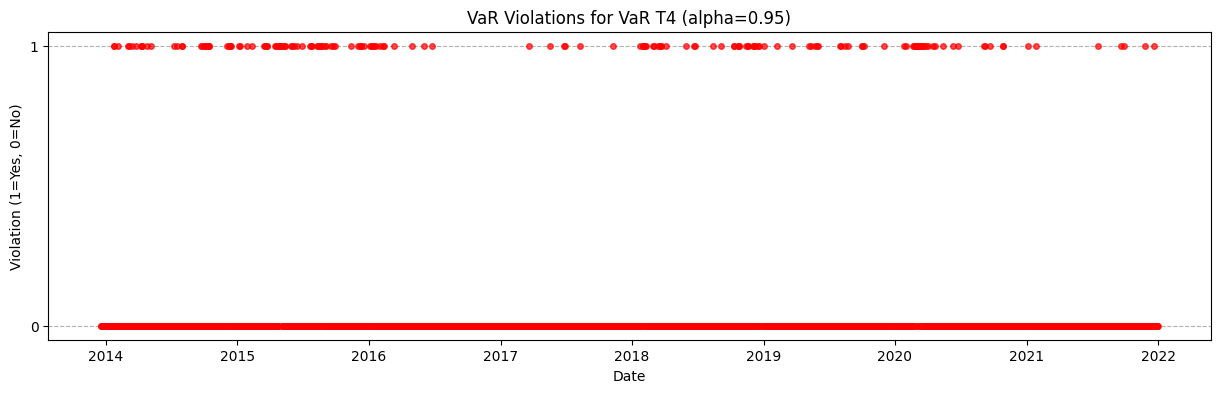


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.080000,8
2014,7,2.550000,255
2015,16,2.540000,254
2016,1,2.570000,257
2017,0,2.550000,255
2018,8,2.530000,253
2019,5,2.530000,253
2020,13,2.550000,255
2021,1,2.570000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,179775.777259,200254.157823,7
2015,299610.721736,303544.917253,16
2016,351547.269932,417705.581257,1
2018,286383.111767,300882.042995,8
2019,297005.549830,348209.185823,5
2020,641228.124603,461055.483055,13
2021,575601.041257,682832.715535,1


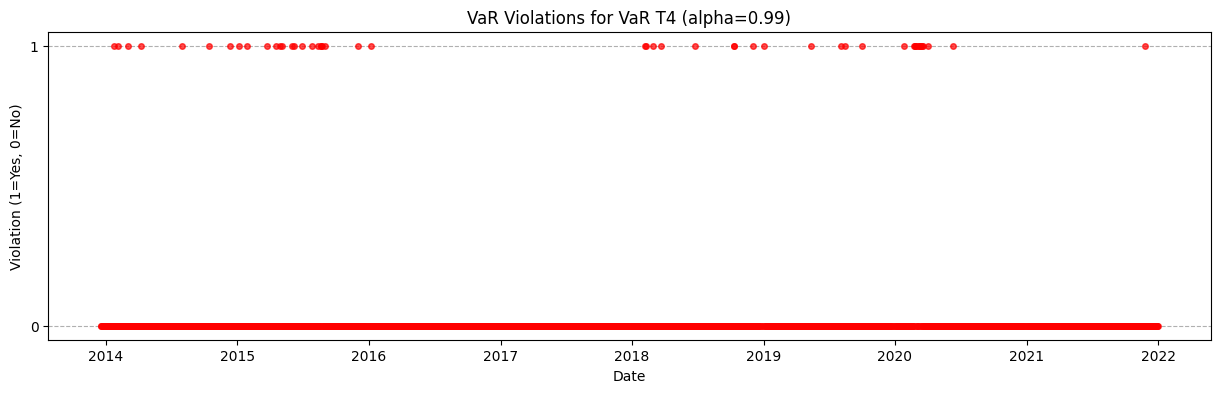


--- Backtesting for Model: VaR T5 ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.400000,8
2014,28,12.750000,255
2015,41,12.700000,254
2016,9,12.850000,257
2017,3,12.750000,255
2018,31,12.650000,253
2019,16,12.650000,253
2020,27,12.750000,255
2021,5,12.850000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,127474.407200,121630.688544,28
2015,221947.393472,184963.671038,41
2016,245764.980182,261394.268796,9
2017,220400.343617,248998.270383,3
2018,200130.746744,183533.792518,31
2019,231804.299531,212249.875886,16
2020,472195.475551,313766.849044,27
2021,369748.481860,412301.686231,5


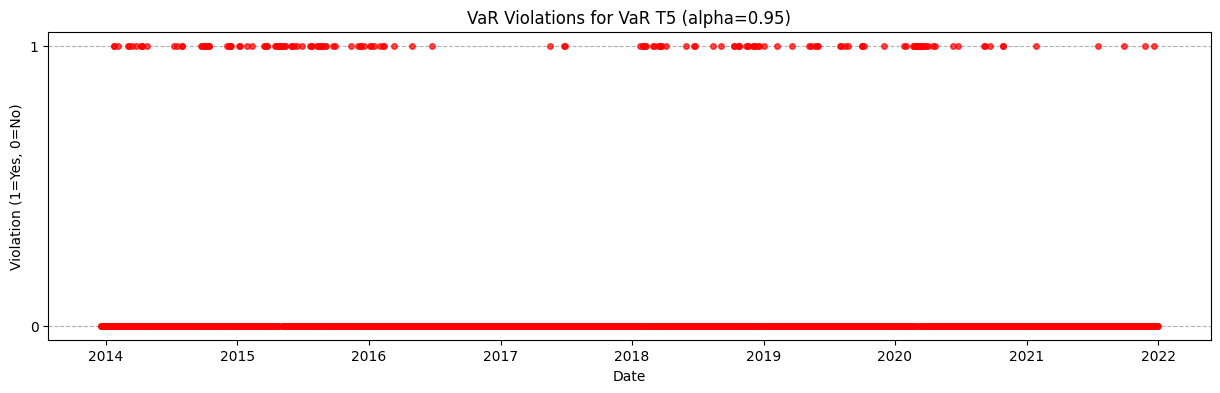


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.080000,8
2014,7,2.550000,255
2015,17,2.540000,254
2016,1,2.570000,257
2017,0,2.550000,255
2018,9,2.530000,253
2019,5,2.530000,253
2020,13,2.550000,255
2021,1,2.570000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,179775.777259,186844.259356,7
2015,297575.746271,287045.004711,17
2016,351547.269932,390020.116529,1
2018,278426.553697,280866.522900,9
2019,297005.549830,325202.291751,5
2020,641228.124603,430621.850929,13
2021,575601.041257,637449.906260,1


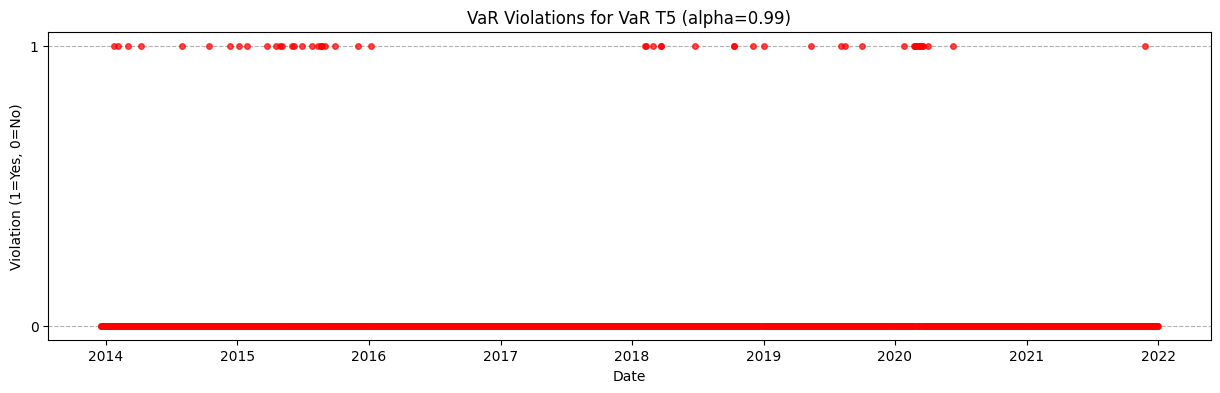


--- Backtesting for Model: VaR T6 ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.400000,8
2014,28,12.750000,255
2015,41,12.700000,254
2016,9,12.850000,257
2017,3,12.750000,255
2018,30,12.650000,253
2019,16,12.650000,253
2020,27,12.750000,255
2021,4,12.850000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,127474.407200,120208.413898,28
2015,221947.393472,182795.662088,41
2016,245764.980182,258398.724305,9
2017,220400.343617,246147.832680,3
2018,202672.170657,181565.240693,30
2019,231804.299531,209823.406390,16
2020,472195.475551,310190.169988,27
2021,388888.445135,405590.514099,4


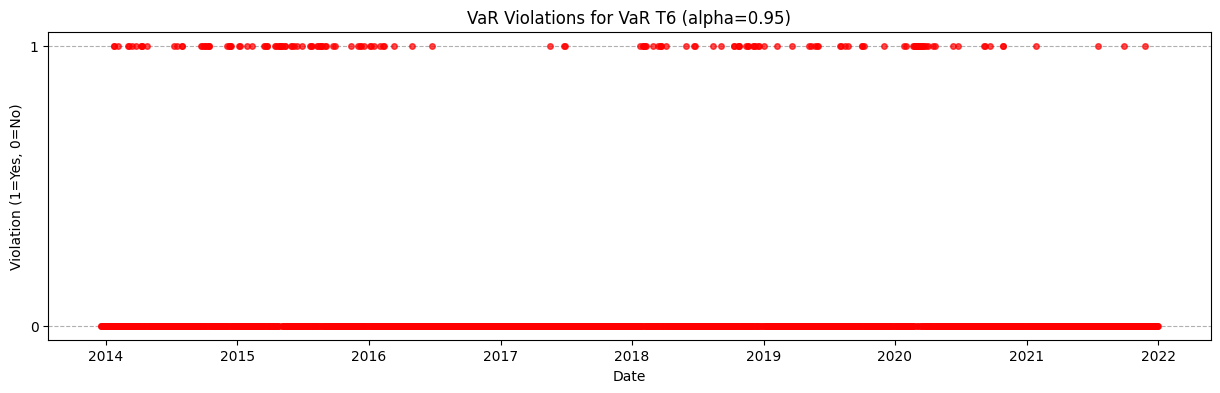


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.080000,8
2014,7,2.550000,255
2015,18,2.540000,254
2016,1,2.570000,257
2017,0,2.550000,255
2018,10,2.530000,253
2019,5,2.530000,253
2020,14,2.550000,255
2021,1,2.570000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,179775.777259,178207.742216,7
2015,293488.314354,274408.631364,18
2016,351547.269932,372189.557165,1
2018,270724.698869,267132.585910,10
2019,297005.549830,310384.921171,5
2020,629342.984889,424621.689973,14
2021,575601.041257,608221.541020,1


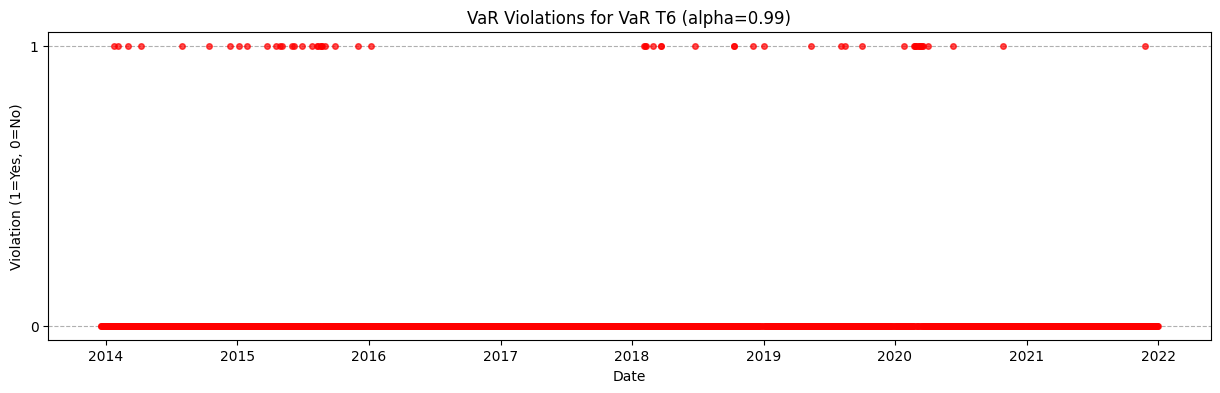


--- Backtesting for Model: VaR Historical ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.400000,8
2014,27,12.750000,255
2015,39,12.700000,254
2016,7,12.850000,257
2017,3,12.750000,255
2018,27,12.650000,253
2019,13,12.650000,253
2020,27,12.750000,255
2021,5,12.850000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,128777.469881,125501.572969,27
2015,227072.609816,196418.111874,39
2016,257968.714712,282523.749871,7
2017,220400.343617,275210.049518,3
2018,209631.041495,195629.120656,27
2019,244184.577059,236283.804872,13
2020,476939.638751,392817.016182,27
2021,369748.481860,506518.996898,5


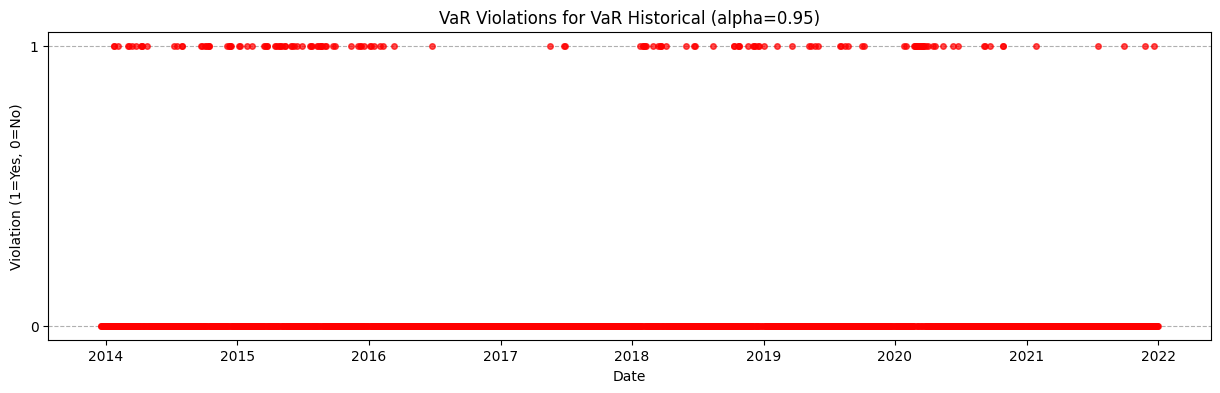


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.080000,8
2014,7,2.550000,255
2015,14,2.540000,254
2016,1,2.570000,257
2017,0,2.550000,255
2018,8,2.530000,253
2019,5,2.530000,253
2020,10,2.550000,255
2021,0,2.570000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,177716.101099,171450.129245,7
2015,312159.951928,275191.404353,14
2016,351547.269932,428332.323854,1
2018,286383.111767,270660.091418,8
2019,297005.549830,322629.692461,5
2020,722801.810819,573681.436089,10


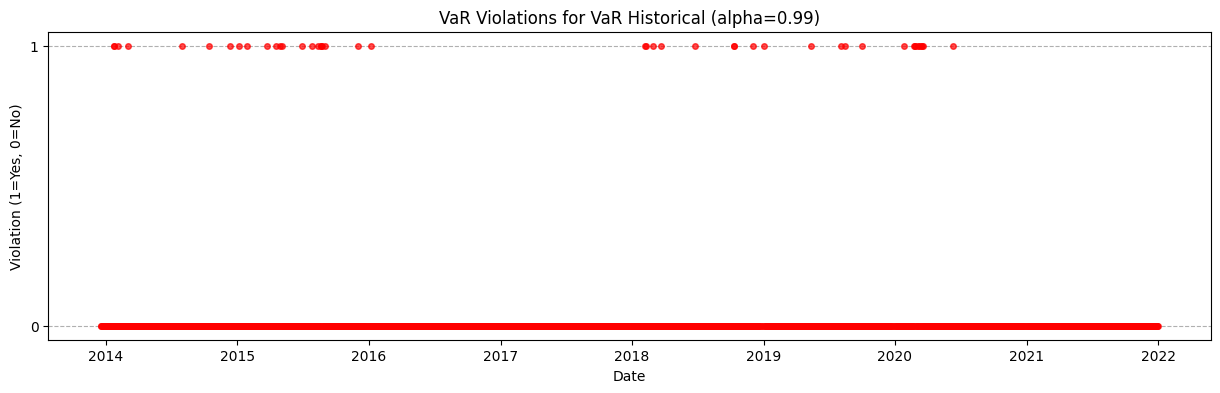

In [24]:
# Call the backtesting function with the required dataframes
run_backtesting(main_df, var_results_df, es_results_df)

### Backtesting Interpretation

Review the tables and plots above:

*   **VaR Backtest:** Compare 'Actual Violations' to 'Expected Violations' each year. Significant deviations might indicate issues with the VaR model's calibration. If actual violations consistently exceed expected, the model underestimates risk. If they are consistently lower, it might be too conservative.
*   **ES Backtest:** Compare 'Avg Actual Shortfall' to 'Avg Predicted ES'. If the actual average shortfall during violations is consistently higher than the predicted ES, the model underestimates the severity of tail losses.
*   **Violation Plots:** Look for patterns. Ideally, violations should be randomly distributed. Clustering of violations suggests the model fails to adapt quickly to changing market volatility (violation dependence).


In [ ]:
# checking assumption on taking mean = 0 
# Calculate portfolio daily returns
main_df['Portfolio_Daily_Returns'] = (
    weights['S&P500'] * main_df['C_S&P500_Returns'] +
    weights['DAX40'] * main_df['C_Dax40_Returns'] +
    weights['NIKKEI'] * main_df['C_Nikkei_Returns'] +
    weights['EU-BOND'] * main_df['Interest_Bond_daily_rate']
)

# make a graph of the portfolio daily returns
plt.figure(figsize=(12, 6))
plt.plot(main_df['Date'], main_df['Portfolio_Daily_Returns'], label='Portfolio Daily Returns', color='blue')
plt.title('Portfolio Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid()
#plt.show()

# Calculate the mean of the returns for each stock over a subset of the data defined on the time range
# Define the sample size
sample_size = 500

# Initialize variables to store the mean returns for each stock for each time window
mean_sp500_returns_list = []
mean_dax40_returns_list = []
mean_nikkei_returns_list = []
mean_eu_bond_returns_list = []

# Loop through the data with a fixed sample size
for i in range(sample_size, len(main_df)):
    time_range_start = main_df['Date'].iloc[i - sample_size]
    time_range_end = main_df['Date'].iloc[i]
    time_range_df = main_df[(main_df['Date'] >= time_range_start) & (main_df['Date'] <= time_range_end)]
    
    # Calculate mean returns for each stock
    mean_sp500_returns = time_range_df['C_S&P500_Returns'].mean()
    mean_dax40_returns = time_range_df['C_Dax40_Returns'].mean()
    mean_nikkei_returns = time_range_df['C_Nikkei_Returns'].mean()
    mean_eu_bond_returns = time_range_df['Interest_Bond_daily_rate'].mean()
    
    # Append the results to the respective lists
    mean_sp500_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean S&P500 Returns': mean_sp500_returns
    })
    mean_dax40_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean DAX40 Returns': mean_dax40_returns
    })
    mean_nikkei_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean Nikkei Returns': mean_nikkei_returns
    })
    mean_eu_bond_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean EU Bond Returns': mean_eu_bond_returns
    })

# Convert the results to DataFrames for easier analysis
mean_sp500_returns_df = pd.DataFrame(mean_sp500_returns_list)
mean_dax40_returns_df = pd.DataFrame(mean_dax40_returns_list)
mean_nikkei_returns_df = pd.DataFrame(mean_nikkei_returns_list)
mean_eu_bond_returns_df = pd.DataFrame(mean_eu_bond_returns_list)

# Display the results
display(mean_sp500_returns_df.head())
display(mean_dax40_returns_df.head())
display(mean_nikkei_returns_df.head())
display(mean_eu_bond_returns_df.head())

# Plot the mean returns for each stock over time
plt.figure(figsize=(12, 6))
plt.plot(mean_sp500_returns_df['End Date'], mean_sp500_returns_df['Mean S&P500 Returns'], label='Mean S&P500 Returns', color='blue')
plt.plot(mean_dax40_returns_df['End Date'], mean_dax40_returns_df['Mean DAX40 Returns'], label='Mean DAX40 Returns', color='orange')
plt.plot(mean_nikkei_returns_df['End Date'], mean_nikkei_returns_df['Mean Nikkei Returns'], label='Mean Nikkei Returns', color='green')
plt.plot(mean_eu_bond_returns_df['End Date'], mean_eu_bond_returns_df['Mean EU Bond Returns'], label='Mean EU Bond Returns', color='red')
plt.title('Mean Returns Over Time for Each Stock')
plt.xlabel('End Date')
plt.ylabel('Mean Returns')
plt.legend()
plt.grid()
plt.show()